In [1]:
import netCDF4 as nc
from netCDF4 import Dataset, num2date, date2num, date2index  # http://code.google.com/p/netcdf4-python/
import datetime as dt 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os

In [2]:
# CODE STARTS HERE
# Define function to get dataset info and apply daily average calculation over multiple files
def process_rhum_data(year):
    # Open the NetCDF file
    dataset = nc.Dataset(f'rhum.{year}.nc')
    # Access the relative humidity data
    rh_var = dataset.variables["rhum"]
    # Load latitude and longitude data
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:] 
    time_var = dataset.variables['time'] 
    dates = num2date(time_var[:], time_var.units)
    dates = np.array([np.datetime64(date) for date in dates])

    # Only keep rhum data from May 1st to October 31st
    start_date = np.datetime64(f'{year}-05-01') 
    end_date = np.datetime64(f'{year}-10-31')    
    mask = (dates >= start_date) & (dates <= end_date)
    filtered_rh = rh_var[mask]
    
    # Calculate daily averages of RH
    daily_averages = [] 
    unique_dates = np.unique(dates[mask])
    for date in unique_dates:
        daily_data = filtered_rh[dates[mask] == date]
        daily_average = np.mean(daily_data)
        daily_averages.append((date, daily_average))

    # Create new DataFrame for daily averages
    daily_avg_df = pd.DataFrame(daily_averages, columns=['Date', 'Daily Average RH'])
    daily_avg_df.to_csv(f'daily_average_rh_{year}.csv', index=False)

years = range(2009, 2019)

# Process RH data for years 2009 to 2019
for year in range(2009, 2019):
    process_rhum_data(year)

# Load daily RH % averages per year data 
def load_daily_rh_data(years):
    data_frames = {}
    for year in years:
        file_path = f"C:/Users/308ca/Desktop/Graduate_Fall24_Courses/CLIMATE588_Regional_Climate_Scale/588_final/RH_NCAR_NCEP_Data/Daily_Average_CSVs/daily_average_rh_{year}.csv"
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date']) 
        df.set_index('Date', inplace=True)
        data_frames[year] = df
    return data_frames

# Load daily average RH data for merging
def load_daily_average_rh(years):
    daily_avg_rh = {}
    for year in years:
        file_path = f'daily_average_rh_{year}.csv'
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        daily_avg_rh[year] = df.set_index('Date')
    return daily_avg_rh

# Load daily average RH data
daily_avg_rh_data = load_daily_average_rh(years)

# Load NDVI data
def load_ndvi_data(years):
    data_frames = {}
    for year in years:
        file_path = f"C:/Users/308ca/Desktop/Graduate_Fall24_Courses/CLIMATE588_Regional_Climate_Scale/588_final/MODIS_NDVI_Data/{year}_Daily_NDVI.csv"
        df = pd.read_csv(file_path)
        if df.shape[1] > 2 and df.columns[2].startswith('Unnamed'):
            df.drop(df.columns[2], axis=1, inplace=True)
        data_frames[year] = df  
    return data_frames

# Load NDVI data
years = range(2009, 2019)
daily_NDVI_data = load_ndvi_data(years)

# Convert 'acq_date' to datetime and interpolate missing values
for year in years:
    daily_NDVI_data[year]['Date'] = pd.to_datetime(daily_NDVI_data[year]['Date'], format='mixed')
    daily_NDVI_data[year]['NDVI Value'] = daily_NDVI_data[year]['NDVI Value'].interpolate(method='linear')

daily_NDVI_data

{2009:           Date  NDVI Value
 0   2009-01-01       0.094
 1   2009-01-02       0.089
 2   2009-01-03       0.059
 3   2009-01-04       0.053
 4   2009-01-05       0.088
 ..         ...         ...
 359 2009-12-26       0.057
 360 2009-12-27       0.044
 361 2009-12-28       0.045
 362 2009-12-29       0.051
 363 2009-12-30       0.016
 
 [364 rows x 2 columns],
 2010:           Date  NDVI Value
 0   2010-01-01       0.068
 1   2010-01-02       0.050
 2   2010-01-03       0.045
 3   2010-01-04       0.053
 4   2010-01-05       0.035
 ..         ...         ...
 359 2010-12-26       0.046
 360 2010-12-27       0.072
 361 2010-12-28       0.059
 362 2010-12-29       0.011
 363 2010-12-30       0.037
 
 [364 rows x 2 columns],
 2011:           Date  NDVI Value
 0   2011-01-01       0.066
 1   2011-01-02       0.138
 2   2011-01-03       0.132
 3   2011-01-04       0.138
 4   2011-01-05       0.099
 ..         ...         ...
 359 2011-12-26       0.128
 360 2011-12-27       0.101
 361

In [3]:
# Load fire detection data
def load_fire_data(year):
    file_path = f"C:/Users/308ca/Desktop/Graduate_Fall24_Courses/CLIMATE588_Regional_Climate_Scale/588_final/Fire_Detections_w_Landcover/withLandCoverValues_{year}_MODIS_Midwest_Veg_Fire_Detections_Harvest_Season_TableToExcel.xlsx"
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return pd.DataFrame()  
    df = pd.read_excel(file_path)
    return df[['OBJECTID', 'latitude', 'longitude', 'acq_date', 'month', 'year', 'LandCoverValue', 'LandCoverType', 'LandCoverValueID', 'LandCoverTypeID']]

# Load data for each year from 2009 to 2018
years = range(2009, 2019)
data_frames = {}
for year in years:
    data_frames[f'df_{year}'] = load_fire_data(year)

# create data frames from 2009-2019 for fire detections
data_frames = {}
for year in years:
    data_frames[f'df_{year}'] = load_fire_data(year)
# Accessing individual DataFrames
df_2009 = data_frames['df_2009']
df_2010 = data_frames['df_2010']
df_2011 = data_frames['df_2011']
df_2012 = data_frames['df_2012']
df_2013 = data_frames['df_2013']
df_2014 = data_frames['df_2014']
df_2015 = data_frames['df_2015']
df_2016 = data_frames['df_2016']
df_2017 = data_frames['df_2017']
df_2018 = data_frames['df_2018']

# concatenate all data frames
all_data = pd.concat([load_fire_data(year) for year in years if not load_fire_data(year).empty])
all_data['acq_date'] = pd.to_datetime(all_data['acq_date'])
# Group by month and count detections
monthly_data = all_data.groupby(all_data['acq_date'].dt.month).size()
all_data

,OBJECTID,latitude,longitude,acq_date,month,year,LandCoverValue,LandCoverType,LandCoverValueID,LandCoverTypeID
0,1,36.64200,-94.56720,2009-09-27,9,2009,141,NaN,1.0,Corn
1,2,36.64500,-94.55110,2009-09-27,9,2009,141,NaN,2.0,Cotton
2,3,36.64000,-94.57000,2009-09-29,9,2009,141,NaN,3.0,Rice
3,4,36.58560,-93.80030,2009-09-30,9,2009,141,NaN,4.0,Sorghum
4,5,36.58400,-93.81380,2009-09-30,9,2009,141,NaN,5.0,Soybeans
...,...,...,...,...,...,...,...,...,...,...
28695,31561,48.85832,-94.89249,2018-08-22,8,2018,176,NaN,NaN,NaN
28696,31562,48.85843,-95.25021,2018-10-23,10,2018,190,NaN,NaN,NaN
28697,31563,48.61067,-94.64634,2018-05-12,5,2018,195,NaN,NaN,NaN
28698,31564,48.72762,-94.61402,2018-05-23,5,2018,195,NaN,NaN,NaN


In [4]:
# Function to create mapping dictionary
def create_mapping_dict(df):
    mapping_dict = {}
    for value_id, value_type in zip(df['LandCoverValueID'], df['LandCoverTypeID']):
        if pd.isnull(value_type):
            break
        mapping_dict[value_id] = value_type
    return mapping_dict

# Create mapping dictionaries for each year
mapping_dicts = {
    2009: create_mapping_dict(df_2009),
    2010: create_mapping_dict(df_2010),
    2011: create_mapping_dict(df_2011),
    2012: create_mapping_dict(df_2012),
    2013: create_mapping_dict(df_2013),
    2014: create_mapping_dict(df_2014),
    2015: create_mapping_dict(df_2015),
    2016: create_mapping_dict(df_2016),
    2017: create_mapping_dict(df_2017),
    2018: create_mapping_dict(df_2018)
}

# Combine mapping dictionaries into one, avoiding duplicates
combined_mapping_dict = {}
for year, mapping in mapping_dicts.items():
    combined_mapping_dict.update(mapping)

# Fill in empty LandcoverType entries with the mapping_dict of values and corresponding landcover types
def fill_land_cover_type(row):
    if pd.isnull(row['LandCoverType']):
        # Ensure we are using the correct key for mapping
        land_cover_value = row['LandCoverValue']
        if pd.notnull(land_cover_value):
            return combined_mapping_dict.get(land_cover_value, "Unknown")
    return row['LandCoverType']

# Apply the filling function to all data frames
all_data['LandCoverType'] = all_data.apply(fill_land_cover_type, axis=1)

In [5]:
# Create a new column in all_data with daily average RH values
all_data['Daily Average RH %'] = None  # Initialize the new column

# Populate the new column with daily average RH values
for year in years:
    year_data = daily_avg_rh_data[year]
    # Merge daily average RH values based on acq_date
    all_data.loc[all_data['acq_date'].dt.year == year, 'Daily Average RH %'] = all_data.loc[all_data['acq_date'].dt.year == year, 'acq_date'].map(year_data['Daily Average RH'])

# Create a new column in all_data for NDVI values
all_data['NDVI Value'] = None  # Initialize the new column

# Populate the new column with NDVI values
for year in years:
    year_ndvi_data = daily_NDVI_data[year]
    # Merge NDVI values based on acq_date
    all_data.loc[all_data['acq_date'].dt.year == year, 'NDVI Value'] = all_data.loc[all_data['acq_date'].dt.year == year, 'acq_date'].map(year_ndvi_data.set_index('Date')['NDVI Value'])
    
# Remove type ID column that used to make the dictionary and no longer needed
all_data = all_data.drop('LandCoverTypeID', axis=1)

# Create a new column for fire detection per date
all_data['Daily Fire Detections'] = 1  # Each row represents a fire detection
all_data

,OBJECTID,latitude,longitude,acq_date,month,year,LandCoverValue,LandCoverType,LandCoverValueID,Daily Average RH %,NDVI Value,Daily Fire Detections
0,1,36.64200,-94.56720,2009-09-27,9,2009,141,Deciduous Forest,1.0,33.700527,0.33,1
1,2,36.64500,-94.55110,2009-09-27,9,2009,141,Deciduous Forest,2.0,33.700527,0.33,1
2,3,36.64000,-94.57000,2009-09-29,9,2009,141,Deciduous Forest,3.0,32.991512,0.325,1
3,4,36.58560,-93.80030,2009-09-30,9,2009,141,Deciduous Forest,4.0,33.083435,0.33,1
4,5,36.58400,-93.81380,2009-09-30,9,2009,141,Deciduous Forest,5.0,33.083435,0.33,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28695,31561,48.85832,-94.89249,2018-08-22,8,2018,176,Grassland/Pasture,NaN,34.419964,0.431,1
28696,31562,48.85843,-95.25021,2018-10-23,10,2018,190,Woody Wetlands,NaN,33.27435,0.321,1
28697,31563,48.61067,-94.64634,2018-05-12,5,2018,195,Herbaceous Wetlands,NaN,32.885815,0.201,1
28698,31564,48.72762,-94.61402,2018-05-23,5,2018,195,Herbaceous Wetlands,NaN,32.939613,0.329,1


In [8]:
# Construct pearson correlation coefficient matrix between Daily Fire Detections, LandCoverType	, Daily Average RH %, and NDVI Value columns, which are all columns in all_data dataframe
# Select the relevant columns for correlation analysis
corr_df = all_data[['Daily Fire Detections', 'Daily Average RH %', 'NDVI Value']]
corr_df = corr_df.dropna()

# Convert columns to numeric, forcing errors to NaN
all_data['Daily Fire Detections'] = pd.to_numeric(all_data['Daily Fire Detections'], errors='coerce')
all_data['Daily Average RH %'] = pd.to_numeric(all_data['Daily Average RH %'], errors='coerce')
all_data['NDVI Value'] = pd.to_numeric(all_data['NDVI Value'], errors='coerce')

# Save all_data as csv
all_data.to_csv(r'C:/Users/308ca/Desktop/Graduate_Fall24_Courses/CLIMATE588_Regional_Climate_Scale/588_final/Fire_Detections_w_Landcover/all_fire_detections_2009-2019.csv', index = None, header=True)

# Check every entry type under Daily Fire Detections column
unique_values = all_data['Daily Fire Detections'].unique()
print(unique_values)

# Calculate the Pearson correlation coefficient matrix
corr_matrix = corr_df.corr(method='pearson')

print(corr_matrix)

# As we only have 1 for Daily Fire Detections as a column entry, this makes sense as each row represents a different detection
# So, all NaN values in table should be 1s
# Replace all NaN values in the correlation matrix with 1s
corr_matrix = corr_matrix.fillna(1)

print(corr_matrix)

# Put corr_matrix into table, save as image to 3 sig figs, make table smaller image
# Format the correlation matrix to three significant figures
formatted_corr_matrix = np.round(corr_matrix.values, 3)

fig, ax = plt.subplots()
# Create a table from the formatted correlation matrix
table = ax.table(cellText=formatted_corr_matrix, colLabels=corr_matrix.columns, rowLabels=corr_matrix.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
ax.axis('off')  # Hide the axes
plt.savefig('correlation_matrix.png', bbox_inches='tight', dpi=300)
plt.close()

[1]
                       Daily Fire Detections  Daily Average RH %  NDVI Value
Daily Fire Detections                    NaN                 NaN         NaN
Daily Average RH %                       NaN            1.000000    0.561359
NDVI Value                               NaN            0.561359    1.000000
                       Daily Fire Detections  Daily Average RH %  NDVI Value
Daily Fire Detections                    1.0            1.000000    1.000000
Daily Average RH %                       1.0            1.000000    0.561359
NDVI Value                               1.0            0.561359    1.000000


In [64]:
"""We have done a one-to-one mapping where each row that represented a daily fire detection during harvest season of 2009-2019 has a corresponding daily NDVI value, average RH vlue, and landcover type occuring at each detection point. This resulted in a directly linear relationship between daily fire detections and the other environmental variables in this analysis. This one-to-one mapping resulting in a linear tranformation is known as an injection."""

'We have done a one-to-one mapping where each row that represented a daily fire detection during harvest season of 2009-2019 has a corresponding daily NDVI value, average RH vlue, and landcover type occuring at each detection point. This resulted in a directly linear relationship between daily fire detections and the other environmental variables in this analysis. This one-to-one mapping resulting in a linear tranformation is known as an injection.'

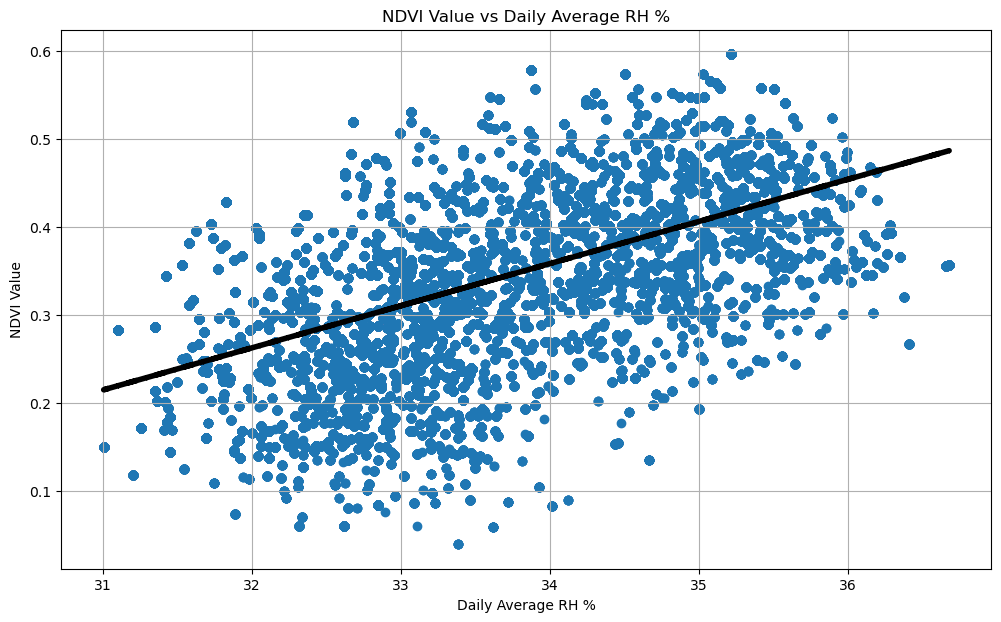

In [55]:
"""This is further seen where most of the PCC matrix values signify a perfectly positive linear correlation. We will plot Daily Average RH % vs NDVI values to determine that functional relationship as it is the only linear relationship in the matrix which is not perfectly positive.."""
# In all_data, plot NDVI Value column vs Daily Average RH % column to determine functional relationship
x = all_data['Daily Average RH %']
y = all_data['NDVI Value']

# Create the scatter plot
plt.figure(figsize=(12, 7))
plt.scatter(x, y)
plt.title('NDVI Value vs Daily Average RH %')
plt.xlabel('Daily Average RH %')
plt.ylabel('NDVI Value')
plt.grid(True)

# Add the regression line
z = np.polyfit(x, y, 1)  # Fit a linear polynomial
p = np.poly1d(z)
plt.plot(x, p(x), color='black', linestyle='--', linewidth=4)

plt.show()

In [53]:
"""This scatter plot, its fitted linear polynomial regression line, and the matrix correlation coefficient value of about 0.56 all show a weak positive trend between daily average relative humidity percentages and daily NDVI values during fire detection dates."""

'This scatter plot, its fitted linear polynomial regression line, and the matrix correlation coefficient value of about 0.56 all show a weak positive trend between daily average relative humidity percentages and daily NDVI values during fire detection dates.'

In [69]:
"""For the injective function environmental variables, we will move on to linear forecasting methods incorporating them in order to predict future fire detections."""

'For the injective function environmental variables, we will move on to linear forecasting methods incorporating them in order to predict future fire detections.'

In [59]:
"""As the other variables (relative humidity and NDVI values against Daily fire detections) had directly positive linearity, which was from the injective function to daily fire detection data, we will move forward to time series forecasting based on histroical data with a model called ARIMA and a Random Forest Model between these variables and daily fire detections."""

'As the other variables (relative humidity and NDVI values against Daily fire detections) had directly positive linearity, which was from the injection to daily fire detection data, we will move forward to time series forecasting based on histroical data with a model called ARIMA and a Random Forest Model between these variables and daily fire detections.'